In [1]:
## 데이터 분석 포트폴리오

### 1. 데이터 로드 및 확인

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
game = pd.read_csv("/content/cookie_cats.csv")

print(game.head())
print(game.tail())
print(game.info())
print(game.describe())


   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64

In [3]:
# 결측치 확인
print(game.isna().sum())

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [4]:
# 중복 확인
print(game[game.duplicated()].head())

Empty DataFrame
Columns: [userid, version, sum_gamerounds, retention_1, retention_7]
Index: []


version
gate_30    44700
gate_40    45489
Name: sum_gamerounds, dtype: int64


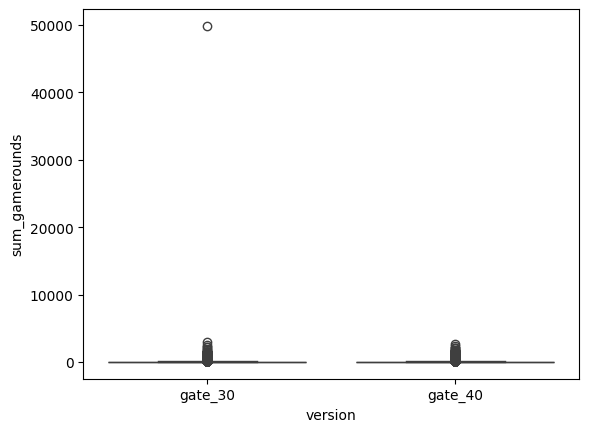

In [5]:
### 2. 이상치 탐색 및 시각화
print(game.groupby("version")["sum_gamerounds"].count())

sns.boxplot(x='version', y='sum_gamerounds', data=game)
plt.show()

         0.900   0.990     0.999    1.000
version                                  
gate_30  135.0  493.00  1052.612  49854.0
gate_40  134.0  492.12  1086.096   2640.0


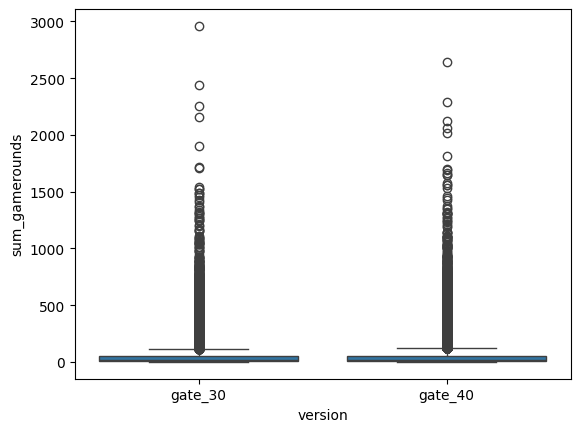

In [6]:
# 이상치 제거 기준 설정
quantiles = game.groupby("version")["sum_gamerounds"].quantile([0.9, 0.99, 0.999, 1]).unstack()
print(quantiles)

new_game = game[game["sum_gamerounds"] < 49854].sort_values(by="sum_gamerounds", ascending=False)

sns.boxplot(x='version', y='sum_gamerounds', data=new_game)
plt.show()

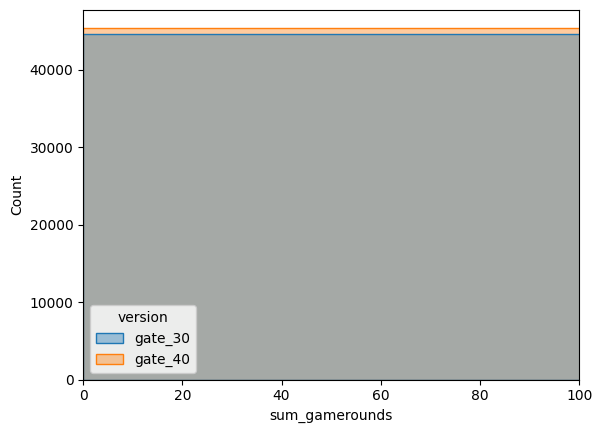

In [7]:
### 3. 탐색적 데이터 분석 (EDA)
# 버전별 플레이수 히스토그램
sns.histplot(data=game, x="sum_gamerounds", hue="version", element='step', alpha=0.4, bins=50)
plt.xlim(0, 100)
plt.show()

In [8]:
# 버전별 총 인원 수 및 평균 게임 플레이 횟수
print(new_game.groupby("version").agg(players=('version', 'count'),
                                       avg=('sum_gamerounds', 'mean'),
                                       median=('sum_gamerounds', 'median'),
                                       max=('sum_gamerounds', 'max')))

         players        avg  median   max
version                                  
gate_30    44699  51.342111    17.0  2961
gate_40    45489  51.298776    16.0  2640


In [9]:
# 버전별 설치 후 한 번도 플레이하지 않은 유저 수
print(new_game[new_game["sum_gamerounds"] == 0].groupby(["version", "retention_1", "retention_7"]).size())

version  retention_1  retention_7
gate_30  False        False          1881
                      True             15
         True         False            40
                      True              1
gate_40  False        False          2002
                      True              9
         True         False            42
                      True              4
dtype: int64


In [10]:
### 4. AB 테스트 수행
gate30 = new_game[new_game["version"] == "gate_30"]
gate40 = new_game[new_game["version"] == "gate_40"]

In [11]:
# 정규성 검정 (샤피로-윌크 검정)
shapiro_test_30 = stats.shapiro(gate30["sum_gamerounds"])
shapiro_test_40 = stats.shapiro(gate40["sum_gamerounds"])
print("Shapiro-Wilk Test for Gate 30:", shapiro_test_30)
print("Shapiro-Wilk Test for Gate 40:", shapiro_test_40)

Shapiro-Wilk Test for Gate 30: ShapiroResult(statistic=0.48864023065329454, pvalue=2.362530702499608e-139)
Shapiro-Wilk Test for Gate 40: ShapiroResult(statistic=0.4825610048898129, pvalue=3.3446548187509243e-140)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44699.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


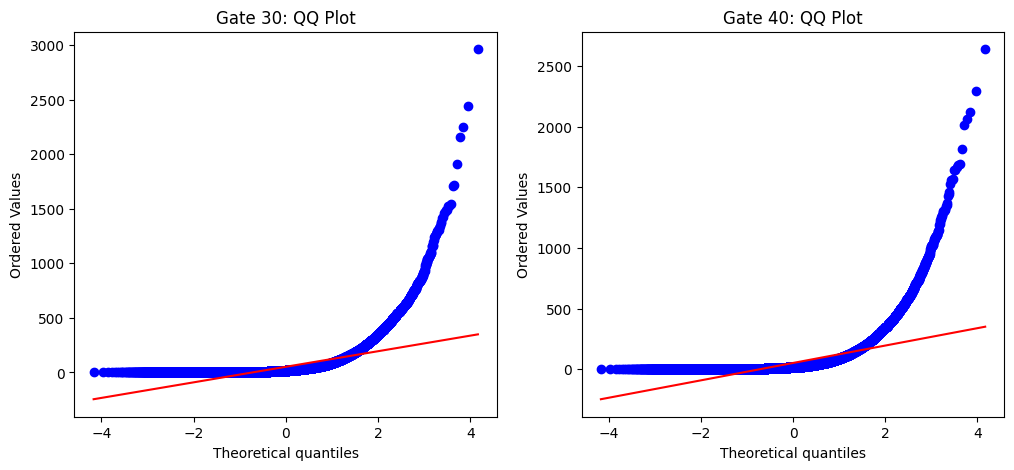

In [12]:
# QQ plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(gate30["sum_gamerounds"], dist="norm", plot=axes[0])
axes[0].set_title("Gate 30: QQ Plot")
stats.probplot(gate40["sum_gamerounds"], dist="norm", plot=axes[1])
axes[1].set_title("Gate 40: QQ Plot")
plt.show()

In [13]:
# 비모수 검정 (윌콕슨 순위합 검정)
wilcoxon_test = stats.mannwhitneyu(gate30["sum_gamerounds"], gate40["sum_gamerounds"], alternative='two-sided')
print("Mann-Whitney U Test:", wilcoxon_test)

Mann-Whitney U Test: MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)



### 결론
위의 분석을 통해 두 버전(gate_30과 gate_40)의 플레이어 행동 차이를 검정하였으며, 특정 이상치를 제거한 후에도 두 그룹 간 유의미한 차이가 존재하는지를 확인하기 위해 비모수 검정을 수행하였다. 분석 결과를 통해 적절한 AB 테스트 결론을 도출할 수 있다.
